In [1]:
!pip install -q numpy==1.26.4 torch==2.3.0 transformers==4.40.2 datasets==2.20.0 peft==0.10.0 scikit-learn matplotlib accelerate


In [2]:
import torch
import numpy as np
import os
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

os.environ["WANDB_DISABLED"] = "true"

from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

CONFIG = {
    "model_name": "distilbert-base-uncased",
    "dataset_name": "imdb",
    "max_length": 512,
    "batch_size": 16,
    "learning_rate": 2e-5,
    "num_epochs": 3,
    "seed": 42,
    "output_dir": "/kaggle/working/results",  # Kaggle output path
}

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def load_and_prepare_data(config):
    print("Loading IMDb dataset...")
    dataset = load_dataset(config["dataset_name"])
    print("Loading tokenizer...")
    try:
        tokenizer = AutoTokenizer.from_pretrained(
            config["model_name"],
            use_fast=True,
        )
    except Exception as e:
        print(f"Warning: {e}")
        # Fallback: download and cache first
        from transformers import DistilBertTokenizerFast
        tokenizer = DistilBertTokenizerFast.from_pretrained(config["model_name"])
    
    def tokenize_fn(examples):
        return tokenizer(
            examples["text"],
            max_length=config["max_length"],
            truncation=True,
            padding=True
        )
    
    print("Tokenizing dataset...")
    tokenized = dataset.map(tokenize_fn, batched=True, remove_columns=["text"])
    tokenized = tokenized.rename_column("label", "labels")
    
    return tokenized, tokenizer

def setup_model(config):
    """Load model for full fine-tuning."""
    model = AutoModelForSequenceClassification.from_pretrained(
        config["model_name"],
        num_labels=2
    )
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nTotal parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    return model

def compute_metrics(eval_pred):
    """Compute accuracy and F1 score."""
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    return {"accuracy": accuracy, "f1": f1}

def train_model(model, tokenized_data, config):
    """Train the model."""
    training_args = TrainingArguments(
        output_dir=f"{config['output_dir']}/full_finetuning",
        overwrite_output_dir=True,
        num_train_epochs=config["num_epochs"],
        per_device_train_batch_size=config["batch_size"],
        per_device_eval_batch_size=config["batch_size"],
        learning_rate=config["learning_rate"],
        logging_steps=100,
        evaluation_strategy="epoch", 

        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        seed=config["seed"],
        report_to="none",  # Disable all logging integrations
    )
    
    tokenizer = AutoTokenizer.from_pretrained(
        config["model_name"],
        use_fast=True,
        trust_remote_code=False
    )
    data_collator = DataCollatorWithPadding(tokenizer)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_data["train"],
        eval_dataset=tokenized_data["test"],
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )
    
    print("\nTraining Full Fine-tuning...")
    trainer.train()
    return trainer

def evaluate_and_save(trainer, tokenized_data, config):
    print("\nEvaluating Full Fine-tuning...")
    eval_results = trainer.evaluate()
    
    predictions = trainer.predict(tokenized_data["test"])
    pred_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = tokenized_data["test"]["labels"]
    
    results = {
        "strategy": "Full Fine-tuning",
        "accuracy": eval_results.get("eval_accuracy", 0),
        "f1": eval_results.get("eval_f1", 0),
        "model_size": sum(p.numel() for p in trainer.model.parameters()),
        "trainable_params": sum(p.numel() for p in trainer.model.parameters() if p.requires_grad),
    }
    
    print(f"\nFull Fine-tuning Results:")
    print(f"  Accuracy: {results['accuracy']:.4f}")
    print(f"  F1-score: {results['f1']:.4f}")
    print(f"  Total params: {results['model_size']:,}")
    print(f"  Trainable params: {results['trainable_params']:,}")
    
    # Save results
    os.makedirs(config["output_dir"], exist_ok=True)
    results_summary = {
        "timestamp": datetime.now().isoformat(),
        "config": config,
        "results": results,
    }
    
    with open(f"{config['output_dir']}/full_finetuning_results.json", "w") as f:
        json.dump(results_summary, f, indent=2)
    print(f"\n✓ Results saved to: {config['output_dir']}/full_finetuning_results.json")
    
    return results, pred_labels, true_labels

def main():
    set_seed(CONFIG["seed"])
    os.makedirs(CONFIG["output_dir"], exist_ok=True)
    
    print("="*60)
    print("STRATEGY 1: FULL FINE-TUNING")
    print("="*60)
    
    # Load data
    tokenized_data, tokenizer = load_and_prepare_data(CONFIG)
    
    # Setup and train model
    model = setup_model(CONFIG)
    trainer = train_model(model, tokenized_data, CONFIG)
    results, pred_labels, true_labels = evaluate_and_save(trainer, tokenized_data, CONFIG)
    
    print("\n" + "="*60)
    print("FULL FINE-TUNING COMPLETE!")
    print("="*60)

if __name__ == "__main__":
    main()



The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

2025-10-21 00:14:54.190966: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761005694.214437     163 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761005694.221312     163 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


STRATEGY 1: FULL FINE-TUNING
Loading IMDb dataset...


Loading tokenizer...


vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Tokenizing dataset...


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Total parameters: 66,955,010
Trainable parameters: 66,955,010

Training Full Fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.206900,0.205250,0.919080,0.915887
2,0.133200,0.198185,0.931080,0.931061
3,0.091000,0.234357,0.930720,0.931166



Evaluating Full Fine-tuning...



Full Fine-tuning Results:
  Accuracy: 0.9307
  F1-score: 0.9312
  Total params: 66,955,010
  Trainable params: 66,955,010

✓ Results saved to: /kaggle/working/results/full_finetuning_results.json

FULL FINE-TUNING COMPLETE!


In [3]:
!mkdir -p /kaggle/outputs/results_full/
!cp -r /kaggle/working/results/* /kaggle/outputs/results_full/
!ls /kaggle/outputs/results_full/


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


full_finetuning  full_finetuning_results.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [ ]:
import torch
import numpy as np
import os
import json
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

os.environ["WANDB_DISABLED"] = "true"

from datasets import load_dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer, DataCollatorWithPadding
)
# ==== Prompted by GPT to bypass chat template bug ====
import transformers.utils.hub as hub_utils
hub_utils.list_repo_templates = lambda *args, **kwargs: []

from peft import get_peft_model, LoraConfig, TaskType
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt

CONFIG = {
    "model_name": "distilbert-base-uncased",
    "dataset_name": "imdb",
    "max_length": 512,
    "batch_size": 16,
    "learning_rate": 2e-5,
    "num_epochs": 3,
    "seed": 42,
    "output_dir": "/kaggle/working/results",
    "lora_r": 8,
    "lora_alpha": 32,
    "lora_dropout": 0.1,
}

def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def load_and_prepare_data(config):
    print("Loading IMDb dataset...")
    dataset = load_dataset(config["dataset_name"])
    

    tokenizer = AutoTokenizer.from_pretrained(
        config["model_name"],
        use_fast=True,
        trust_remote_code=False
    )
    
    def tokenize_fn(examples):
        return tokenizer(
            examples["text"],
            max_length=config["max_length"],
            truncation=True,
            padding=True
        )
    
    print("Tokenizing dataset...")
    tokenized = dataset.map(tokenize_fn, batched=True, remove_columns=["text"])
    tokenized = tokenized.rename_column("label", "labels")
    
    return tokenized, tokenizer

def setup_lora_model(config):
    model = AutoModelForSequenceClassification.from_pretrained(
        config["model_name"],
        num_labels=2
    )
    
    # Print all module names to debug
    print("\nFinding Linear layers in model...")
    linear_layers = []
    for name, module in model.named_modules():
        if 'Linear' in str(type(module)):
            linear_layers.append(name)
            if len(linear_layers) <= 10: 
                print(f"  {name}")

    target_modules = ["q_lin", "k_lin", "v_lin"]
    
 
    
    peft_config = LoraConfig(
        task_type=TaskType.SEQ_CLS,
        r=config["lora_r"],
        lora_alpha=config["lora_alpha"],
        lora_dropout=config["lora_dropout"],
        target_modules=target_modules,
        bias="none",
    )
    
    print(f"\nApplying LoRA with target_modules: {target_modules}")
    try:
        model = get_peft_model(model, peft_config)
        model.print_trainable_parameters()
    except ValueError as e:
        print(f"\n Error: {e}")
        print("\nAvailable linear layers found:")
        for layer in linear_layers[:20]:
            print(f"  - {layer}")
        raise
    
    return model

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    return {"accuracy": accuracy, "f1": f1}

def train_model(model, tokenized_data, config):
    training_args = TrainingArguments(
        output_dir=f"{config['output_dir']}/lora_finetuning",
        overwrite_output_dir=True,
        num_train_epochs=config["num_epochs"],
        per_device_train_batch_size=config["batch_size"],
        per_device_eval_batch_size=config["batch_size"],
        learning_rate=config["learning_rate"],
        logging_steps=100,
        evaluation_strategy="epoch",  

        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="f1",
        seed=config["seed"],
        report_to="none",  
    )
    
    tokenizer = AutoTokenizer.from_pretrained(
        config["model_name"],
        use_fast=True,
        trust_remote_code=False
    )
    data_collator = DataCollatorWithPadding(tokenizer)
    
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=tokenized_data["train"],
        eval_dataset=tokenized_data["test"],
        compute_metrics=compute_metrics,
        data_collator=data_collator,
    )
    
    print("\nTraining LoRA Fine-tuning...")
    trainer.train()
    return trainer

def evaluate_and_save(trainer, tokenized_data, config):
    print("\nEvaluating LoRA Fine-tuning...")
    eval_results = trainer.evaluate()
    
    predictions = trainer.predict(tokenized_data["test"])
    pred_labels = np.argmax(predictions.predictions, axis=1)
    true_labels = tokenized_data["test"]["labels"]
    
    results = {
        "strategy": "LoRA Fine-tuning",
        "accuracy": eval_results.get("eval_accuracy", 0),
        "f1": eval_results.get("eval_f1", 0),
        "model_size": sum(p.numel() for p in trainer.model.parameters()),
        "trainable_params": sum(p.numel() for p in trainer.model.parameters() if p.requires_grad),
        "lora_config": {
            "r": config["lora_r"],
            "alpha": config["lora_alpha"],
            "dropout": config["lora_dropout"],
        }
    }
    
    print(f"\nLoRA Fine-tuning Results:")
    print(f"  Accuracy: {results['accuracy']:.4f}")
    print(f"  F1-score: {results['f1']:.4f}")
    print(f"  Total params: {results['model_size']:,}")
    print(f"  Trainable params: {results['trainable_params']:,}")
    print(f"  LoRA rank: {config['lora_r']}")
    
    os.makedirs(config["output_dir"], exist_ok=True)
    results_summary = {
        "timestamp": datetime.now().isoformat(),
        "config": config,
        "results": results,
    }
    
    with open(f"{config['output_dir']}/lora_results.json", "w") as f:
        json.dump(results_summary, f, indent=2)
    print(f"\n✓ Results saved to: {config['output_dir']}/lora_results.json")
    
    return results, pred_labels, true_labels

def main():
    set_seed(CONFIG["seed"])
    os.makedirs(CONFIG["output_dir"], exist_ok=True)
    
    print("="*60)
    print("STRATEGY 2: LORA FINE-TUNING")
    print("="*60)

    # Prepare and train the model

    tokenized_data, tokenizer = load_and_prepare_data(CONFIG)
    
    model = setup_lora_model(CONFIG)
    trainer = train_model(model, tokenized_data, CONFIG)
    results, pred_labels, true_labels = evaluate_and_save(trainer, tokenized_data, CONFIG)
    
    print("\n" + "="*60)
    print("LORA FINE-TUNING COMPLETE!")
    print("="*60)

if __name__ == "__main__":
    main()

STRATEGY 2: LORA FINE-TUNING
Loading IMDb dataset...
Tokenizing dataset...


Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/25000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Finding Linear layers in model...
  distilbert.transformer.layer.0.attention.q_lin
  distilbert.transformer.layer.0.attention.k_lin
  distilbert.transformer.layer.0.attention.v_lin
  distilbert.transformer.layer.0.attention.out_lin
  distilbert.transformer.layer.0.ffn.lin1
  distilbert.transformer.layer.0.ffn.lin2
  distilbert.transformer.layer.1.attention.q_lin
  distilbert.transformer.layer.1.attention.k_lin
  distilbert.transformer.layer.1.attention.v_lin
  distilbert.transformer.layer.1.attention.out_lin

Applying LoRA with target_modules: ['q_lin', 'k_lin', 'v_lin']
trainable params: 813,314 || all params: 67,768,324 || trainable%: 1.2001388731407907

Training LoRA Fine-tuning...


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.273400,0.264179,0.889720,0.888557
2,0.262500,0.247060,0.899400,0.898536
3,0.268500,0.242762,0.900920,0.901452



Evaluating LoRA Fine-tuning...



LoRA Fine-tuning Results:
  Accuracy: 0.9009
  F1-score: 0.9015
  Total params: 67,768,324
  Trainable params: 813,314
  LoRA rank: 8

✓ Results saved to: /kaggle/working/results/lora_results.json

LORA FINE-TUNING COMPLETE!


✓ Saved: /kaggle/working/plots/metrics_comparison.png
✓ Saved: /kaggle/working/plots/parameter_efficiency.png

RESULTS SUMMARY

Strategy                  Accuracy     F1-Score     Trainable Params    
----------------------------------------------------------------------
Full Fine-tuning          0.9307       0.9312       66.96               M
LoRA Fine-tuning          0.9009       0.9015       0.81                M
----------------------------------------------------------------------

Parameter Reduction: 98.8%
Accuracy Difference: 2.98%

Conclusion: LoRA achieves 98.8% parameter reduction
with only 2.98% accuracy drop!


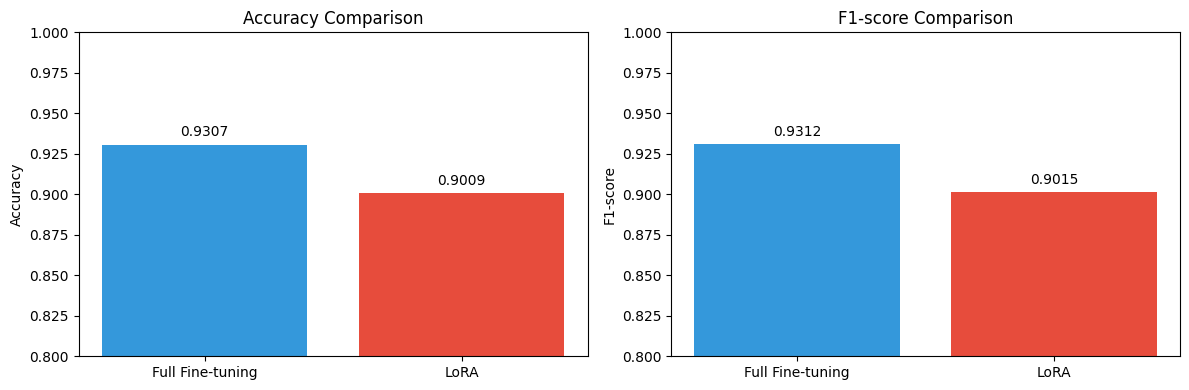

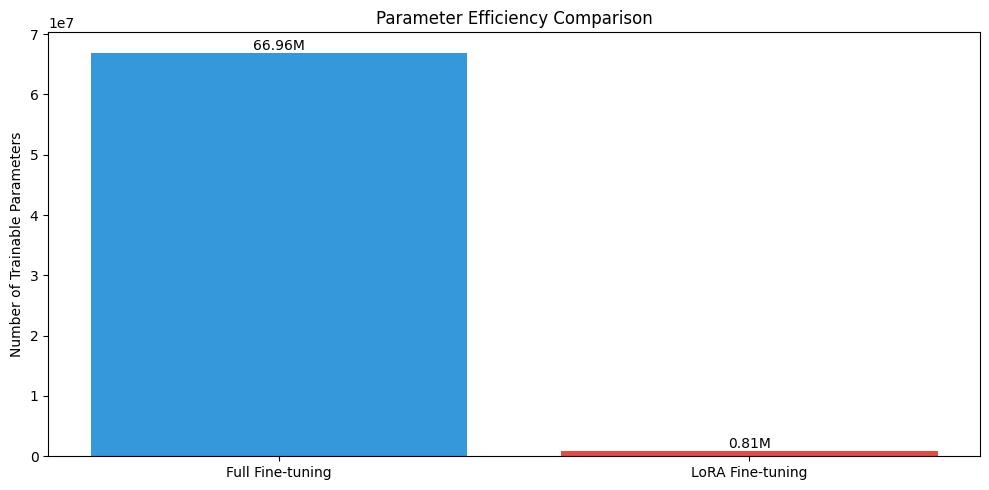

In [5]:
import json
import matplotlib.pyplot as plt
import os

# Load results from both model
def load_results():
    with open("/kaggle/working/results/full_finetuning_results.json", "r") as f:
        full_results = json.load(f)
    
    with open("/kaggle/working/results/lora_results.json", "r") as f:
        lora_results = json.load(f)
    
    return full_results["results"], lora_results["results"]

def plot_comparison(results_full, results_lora):
    """Create comparison visualizations."""
    os.makedirs("/kaggle/working/plots", exist_ok=True)
    
    # Metrics comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    strategies = ["Full Fine-tuning", "LoRA"]
    accuracies = [results_full["accuracy"], results_lora["accuracy"]]
    f1_scores = [results_full["f1"], results_lora["f1"]]
    
    axes[0].bar(strategies, accuracies, color=["#3498db", "#e74c3c"])
    axes[0].set_ylabel("Accuracy")
    axes[0].set_title("Accuracy Comparison")
    axes[0].set_ylim([0.8, 1.0])
    for i, v in enumerate(accuracies):
        axes[0].text(i, v + 0.005, f"{v:.4f}", ha="center")
    
    axes[1].bar(strategies, f1_scores, color=["#3498db", "#e74c3c"])
    axes[1].set_ylabel("F1-score")
    axes[1].set_title("F1-score Comparison")
    axes[1].set_ylim([0.8, 1.0])
    for i, v in enumerate(f1_scores):
        axes[1].text(i, v + 0.005, f"{v:.4f}", ha="center")
    
    plt.tight_layout()
    plt.savefig("/kaggle/working/plots/metrics_comparison.png", dpi=300, bbox_inches="tight")
    print("✓ Saved: /kaggle/working/plots/metrics_comparison.png")
    
    # Parameter efficiency
    fig, ax = plt.subplots(figsize=(10, 5))
    strategies_list = [results_full["strategy"], results_lora["strategy"]]
    trainable = [results_full["trainable_params"], results_lora["trainable_params"]]
    colors = ["#3498db", "#e74c3c"]
    
    bars = ax.bar(strategies_list, trainable, color=colors)
    ax.set_ylabel("Number of Trainable Parameters")
    ax.set_title("Parameter Efficiency Comparison")
    
    for bar, val in zip(bars, trainable):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f"{val/1e6:.2f}M", ha="center", va="bottom")
    
    plt.tight_layout()
    plt.savefig("/kaggle/working/plots/parameter_efficiency.png", dpi=300, bbox_inches="tight")
    print("✓ Saved: /kaggle/working/plots/parameter_efficiency.png")
    
    # Print summary table
    print("\n" + "="*60)
    print("RESULTS SUMMARY")
    print("="*60)
    print(f"\n{'Strategy':<25} {'Accuracy':<12} {'F1-Score':<12} {'Trainable Params':<20}")
    print("-" * 70)
    print(f"{results_full['strategy']:<25} {results_full['accuracy']:<12.4f} {results_full['f1']:<12.4f} {results_full['trainable_params']/1e6:<20.2f}M")
    print(f"{results_lora['strategy']:<25} {results_lora['accuracy']:<12.4f} {results_lora['f1']:<12.4f} {results_lora['trainable_params']/1e6:<20.2f}M")
    print("-" * 70)
    
    param_reduction = (1 - results_lora['trainable_params'] / results_full['trainable_params']) * 100
    acc_diff = (results_full['accuracy'] - results_lora['accuracy']) * 100
    
    print(f"\nParameter Reduction: {param_reduction:.1f}%")
    print(f"Accuracy Difference: {acc_diff:.2f}%")
    print(f"\nConclusion: LoRA achieves {param_reduction:.1f}% parameter reduction")
    print(f"with only {acc_diff:.2f}% accuracy drop!")

if __name__ == "__main__":
    results_full, results_lora = load_results()
    plot_comparison(results_full, results_lora)

In [7]:
!mkdir -p /kaggle/outputs/results_lora/
!cp -r /kaggle/working/results/* /kaggle/outputs/results_lora/
!ls /kaggle/outputs/results_lora/


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


full_finetuning		      lora_finetuning
full_finetuning_results.json  lora_results.json


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
